In [1]:
from pyspark import SparkContext, RDD
import json
import matplotlib.pyplot as plt

sc = SparkContext()

23/05/29 02:24:50 WARN Utils: Your hostname, Laura-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/05/29 02:24:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/29 02:25:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/29 02:25:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/29 02:25:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/05/29 02:25:09 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/05/29 02:25:09 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
23/05/29 02:25:09 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port

In [2]:
rdd = sc.textFile("201906_Usage_Bicimad.json")

#rdd.top(2)

In [3]:
# Obtenemos los datos de Bicimad
def get_stations(line):
    data = json.loads(line)
    salida = data["idunplug_station"]
    entrada = data["idplug_station"]
    user = data["user_type"]
    franja_horaria = data["unplug_hourTime"]["$date"]
    edad = data["ageRange"]
    return salida, entrada, user,franja_horaria, edad

#Filtramos los usuarios, quedándonos con los de tipo 0 y 1 
rdd1 = rdd.map(get_stations).filter(lambda x: x[2]<=1).filter(lambda x: x[0]!=x[1]) 

rdd1.top(5)

[(213, 207, 1, '2019-06-26T19:00:00.000+0200', 0),
 (213, 207, 1, '2019-06-26T19:00:00.000+0200', 0),
 (213, 207, 1, '2019-06-26T12:00:00.000+0200', 0),
 (213, 207, 1, '2019-06-25T19:00:00.000+0200', 0),
 (213, 207, 1, '2019-06-25T19:00:00.000+0200', 0)]

In [4]:
#Eliminamos los trayectos que tienen por entrada y salida la misma 
#estación y guardamos en rdd2 la tupla de los trayectos ordenada.
rdd2 = rdd1.map(lambda x: ((min(x[0],x[1]),max(x[0],x[1])),1)) 

rdd2.top(4)

[((207, 213), 1), ((207, 213), 1), ((207, 213), 1), ((207, 213), 1)]

In [5]:
# Agrupamos los trayectos y obtenemos el numero de veces que se 
#realiza cada uno
rdd3 = rdd2.groupByKey().map(lambda x: (x[0], len(x[1])))
print(rdd3.max(key = (lambda x: x[1])))
maximo = rdd3.max(key = (lambda x: x[1]))[0]

rdd3.top(5)

((9, 149), 490)


[((207, 213), 7),
 ((207, 211), 6),
 ((201, 207), 1),
 ((200, 213), 1),
 ((200, 211), 5)]

In [6]:
# Ordenamos los trayectos de mayor a menor frecuencia
lista_ordenados = rdd3.sortBy(lambda x : x[1]).collect()
lista_ordenados.reverse()

In [7]:
# Seleccionamos los 100 trayectos mas frecuentes  
lista_100mejores = lista_ordenados[:100]
print(lista_100mejores)


[((9, 149), 490), ((49, 135), 434), ((132, 135), 405), ((64, 78), 402), ((149, 169), 380), ((149, 163), 358), ((130, 149), 357), ((157, 163), 322), ((132, 175), 317), ((58, 149), 312), ((26, 175), 310), ((135, 175), 310), ((129, 135), 288), ((57, 135), 284), ((64, 90), 282), ((47, 129), 281), ((52, 135), 280), ((27, 175), 271), ((9, 157), 268), ((118, 163), 266), ((38, 57), 262), ((86, 90), 261), ((1, 175), 260), ((9, 163), 258), ((38, 129), 257), ((129, 175), 253), ((84, 90), 252), ((160, 163), 251), ((42, 135), 249), ((48, 129), 246), ((49, 129), 244), ((57, 129), 243), ((56, 175), 240), ((129, 134), 237), ((83, 115), 236), ((162, 163), 235), ((153, 163), 235), ((130, 157), 229), ((133, 135), 228), ((132, 174), 227), ((149, 168), 226), ((169, 170), 226), ((59, 149), 224), ((45, 135), 223), ((42, 175), 221), ((57, 128), 215), ((79, 90), 213), ((45, 129), 213), ((160, 161), 211), ((26, 57), 210), ((38, 175), 209), ((134, 135), 209), ((30, 157), 206), ((73, 90), 206), ((50, 135), 205), 

In [8]:
# Por cada uno de los 100 trayectos, obtenemos la hora y el dia en el 
#que se realizan
rdd4 = rdd1.map(lambda x: (x[3],(min(x[0],x[1]),max(x[0],x[1]))))
rdd4.top(5)

[('2019-06-26T23:00:00.000+0200', (172, 174)),
 ('2019-06-26T23:00:00.000+0200', (172, 174)),
 ('2019-06-26T23:00:00.000+0200', (172, 173)),
 ('2019-06-26T23:00:00.000+0200', (172, 173)),
 ('2019-06-26T23:00:00.000+0200', (169, 200))]

In [9]:
mejores_trayectos = [x[0] for x in lista_100mejores]
rdd5 = rdd4.filter(lambda x : x[1] in mejores_trayectos)
rdd5.top(5)


[('2019-06-26T23:00:00.000+0200', (164, 171)),
 ('2019-06-26T23:00:00.000+0200', (164, 171)),
 ('2019-06-26T23:00:00.000+0200', (164, 171)),
 ('2019-06-26T23:00:00.000+0200', (164, 171)),
 ('2019-06-26T23:00:00.000+0200', (164, 171))]

In [10]:
# Nos quedamos unicamente con el dato de la hora mas frecuente a la que 
# se realiza el trayecto, con ello podremos contabilizarlas mensualmente
rdd6 = rdd5.map(lambda x: ((x[1], x[0].split("T")[1]),1)).groupByKey().map(lambda x: (x[0] ,len(x[1])))

rdd6.top(5)

[(((169, 170), '23:00:00.000+0200'), 9),
 (((169, 170), '22:00:00.000+0200'), 2),
 (((169, 170), '21:00:00.000+0200'), 13),
 (((169, 170), '20:00:00.000+0200'), 19),
 (((169, 170), '19:00:00.000+0200'), 25)]

In [12]:
# Seleccionamos la hora a la que se realiza ese trayecto con mayor 
#frecuencia, para poder habilitar un carril para ese trayecto mientras 
#se construye el nuevo carril bici
rdd7 = rdd6.map(lambda x: (x[0][0],(x[1],x[0][1]))).groupByKey().map(lambda x: (x[0],max(list(x[1]))))
rdd7.top(5) 

[((169, 170), (27, '10:00:00.000+0200')),
 ((164, 171), (48, '10:00:00.000+0200')),
 ((163, 170), (23, '20:00:00.000+0200')),
 ((163, 166), (17, '20:00:00.000+0200')),
 ((162, 163), (31, '18:00:00.000+0200'))]

In [13]:
# Mostramos los resultados obtenidos
listaResultados = rdd7.collect()
print(listaResultados)

[((9, 157), (35, '21:00:00.000+0200')), ((42, 132), (22, '00:00:00.000+0200')), ((9, 163), (60, '08:00:00.000+0200')), ((25, 175), (25, '18:00:00.000+0200')), ((13, 149), (20, '19:00:00.000+0200')), ((64, 90), (40, '08:00:00.000+0200')), ((38, 135), (18, '16:00:00.000+0200')), ((129, 134), (32, '20:00:00.000+0200')), ((50, 135), (23, '20:00:00.000+0200')), ((149, 164), (21, '09:00:00.000+0200')), ((160, 161), (29, '16:00:00.000+0200')), ((134, 135), (24, '19:00:00.000+0200')), ((149, 161), (22, '19:00:00.000+0200')), ((145, 161), (48, '08:00:00.000+0200')), ((19, 163), (40, '08:00:00.000+0200')), ((59, 131), (24, '00:00:00.000+0200')), ((64, 84), (38, '08:00:00.000+0200')), ((129, 175), (34, '19:00:00.000+0200')), ((42, 57), (24, '19:00:00.000+0200')), ((73, 90), (35, '09:00:00.000+0200')), ((59, 168), (24, '20:00:00.000+0200')), ((42, 135), (32, '16:00:00.000+0200')), ((149, 160), (22, '19:00:00.000+0200')), ((169, 170), (27, '10:00:00.000+0200')), ((65, 84), (30, '07:00:00.000+0200')

Con esto obtenemos los mejores trayectos, el número de veces que se realiza y las mejores horas de cada uno de esos trayectos, que es lo que queríamos 


Ahora veamos una gráfica de para la estacion con mayor frecuencia cómo varía el numero de bicis por hora

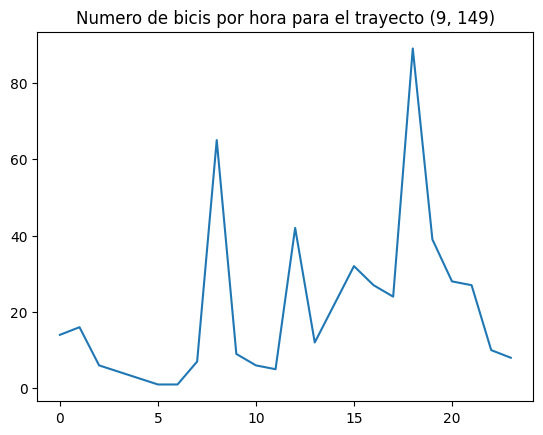

In [14]:
# Graficamos los datos obtenidos
rddGraf = rdd6.filter(lambda x: x[0][0] == maximo).map(lambda x: (int(x[0][1][:2]), x[1])).sortBy(lambda x: x[0])
listaRes = rddGraf.collect()

lx = [x[0] for x in listaRes]
ly = [x[1] for x in listaRes]
plt.plot(lx, ly)
plt.title(f"Numero de bicis por hora para el trayecto {maximo}")
plt.show()

In [15]:
from pyspark import pandas
DF = pandas.DataFrame(data = lista_100mejores[:10], columns =["estacion", "numeroviajes"])

/home/estampida/.local/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [16]:
DF 
# En esta tabla podemos ver los 10 mejores trayectos segun el numero 
#de viajes

,estacion,numeroviajes
0,"[9, 149]",490
1,"[49, 135]",434
2,"[132, 135]",405
3,"[64, 78]",402
4,"[149, 169]",380
5,"[149, 163]",358
6,"[130, 149]",357
7,"[157, 163]",322
8,"[132, 175]",317
9,"[58, 149]",312


(0, 181129)


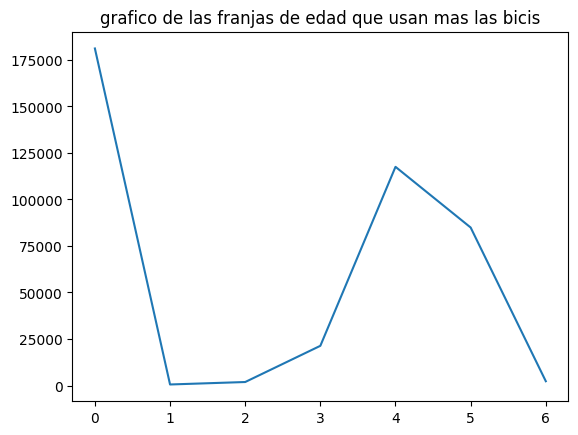

In [17]:
# Obtenemos la franja de edad que mas usa el servicio
rddEdad = rdd1.map(lambda x: (x[4], 1)).groupByKey().map(lambda x: (int(x[0]), len(x[1])))
print(rddEdad.max(key= lambda x: x[1]))

lista_edad = rddEdad.collect()

lex = [x[0] for x in  lista_edad]
ley = [x[1] for x in lista_edad]
plt.plot(lex, ley)
plt.title("grafico de las franjas de edad que usan mas las bicis")
plt.show()